# Summary
データセットをセットアップして，津山高専北館分類器を組む．その後テストセットでの精度を測る．  
考察・改善はモデル生成後に行う．

## データセット生成

In [44]:
from PIL import Image
import tempfile, glob
import random, math
import numpy as np

# CONST VAL
DUMP_DIR = os.getenv('HOME') + "/teraken_overtime_dump"
DATASET_DIR = DUMP_DIR + "/labeled"
LABEL_NAME = ['not_north', 'north']

def make_npdatasets(image_files):
    X = []
    y = []
    for label, image_file in image_files:
        # append to X, y
        X.append(make_npimage(image_file))
        y.append(label)
    return np.array(X), np.array(y)

def make_npimage(image_file):
    RESIZE_VAL = 150 # resized by 150
    image = Image.open(image_file)
    image = image.convert("RGB")
    image = image.resize((RESIZE_VAL, RESIZE_VAL))
    return np.asarray(image) # return image array

def main():
    datasets_array = []

    for i, label in enumerate(LABEL_NAME):
        image_dir = DATASET_DIR + "/" + label
        image_files = glob.glob(image_dir + "/*.jpg")
        for image_file in image_files:
            datasets_array.append((i, image_file))

    # shuffle datasets
    random.shuffle(datasets_array)
    train_size = math.floor(len(datasets_array) * 0.6)
    val_size = math.floor(len(datasets_array) * 0.2)
    X_train, y_train = make_npdatasets(datasets_array[0:train_size])
    X_val, y_val = make_npdatasets(datasets_array[train_size:train_size + val_size])
    X_test, y_test = make_npdatasets(datasets_array[train_size + val_size:])

    # save dataset array
    xy = (X_train, X_val, X_test, y_train, y_val, y_test)
    np.save(DUMP_DIR + "/north_datasets.npy", xy)

if __name__ == "__main__":
    main()


## CNNによる分類

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 128)       147584    
__________

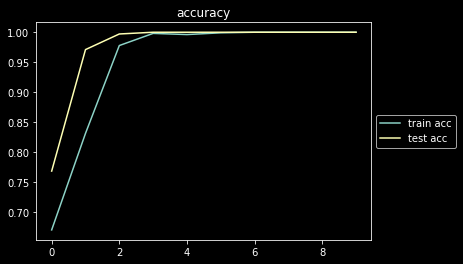

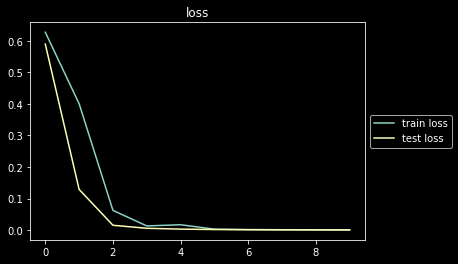

346/346 [==============================] - 6s 16ms/step
test loss: 0.0007683833133405064
test acc: 1.0


In [9]:
from keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import os

# CONST VAL
DUMP_DIR = os.getenv('HOME') + "/teraken_overtime_dump"
DATASET_DIR = os.getenv('HOME') + "/teraken_overtime_dump/labeled"
LABEL_NAME = ['not_north', 'north']

%matplotlib inline

def create_model():
    RESIZE_VAL = 150 # resized by 150
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(RESIZE_VAL, RESIZE_VAL, 3))) # conv layer
    model.add(layers.MaxPooling2D((2, 2))) # pooling layer
    model.add(layers.Conv2D(64, (3, 3), activation="relu")) # conv layer
    model.add(layers.MaxPooling2D((2, 2))) # pooling layer
    model.add(layers.Conv2D(128, (3, 3), activation="relu")) # conv layer
    model.add(layers.MaxPooling2D((2, 2))) # pooling layer
    model.add(layers.Conv2D(128, (3, 3), activation="relu")) # conv layer
    model.add(layers.MaxPooling2D((2, 2))) # pooling layer
    model.add(layers.Flatten()) # flatten layer
    model.add(layers.Dense(512, activation="relu")) # fully connect layer 1
    model.add(layers.Dense(1, activation="sigmoid")) # fully connect layer 2 (output)

    model.summary() # show summary

    model.compile(loss="binary_crossentropy", optimizer='sgd', metrics=["acc"]) # compile model
    return model

def train_model(model, datasets_path):
    X_train, X_val, X_test, y_train, y_val, y_test = np.load(datasets_path)
    X_train = X_train.astype("float") / 255
    X_val = X_val.astype("float") / 255
    model_stack = model.fit(X_train, y_train, epochs=10, batch_size=6, validation_data=(X_val, y_val))
    return model_stack

def show_history(model_stack):
    acc = model_stack.history['acc']
    val_acc = model_stack.history['val_acc']
    loss = model_stack.history['loss']
    val_loss = model_stack.history['val_loss']

    # plot learning curve
    epoch = range(len(acc))
    plt.style.use('dark_background')
    plt.plot(epoch, acc, label="train acc")
    plt.plot(epoch, val_acc, label="val acc")
    plt.title("accuracy")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

    plt.plot(epoch, loss, label='train loss')
    plt.plot(epoch, val_loss, label='val loss')
    plt.title('loss')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
def evaluate_data(model, datasets_path):
    X_train, X_val, X_test, y_train, y_val, y_test = np.load(datasets_path)
    X_test  = X_test.astype("float")  / 255
    eval_stack = model.evaluate(x=X_test, y=y_test)
    return eval_stack

def main():
    datasets_path = DUMP_DIR + "/north_datasets.npy"
    model = create_model()

    model_stack = train_model(model, datasets_path) # training model
    show_history(model_stack)
    
    # evaluate by testsets
    eval_stack = evaluate_data(model, datasets_path)
    print("test loss: " + str(eval_stack[0]))
    print("test acc: " + str(eval_stack[1]))

    # save model
    model_string = model.to_json()
    open(DUMP_DIR + "/north_model_cnn.json", 'w').write(model_string)

    # save parameter
    model.save_weights(DUMP_DIR + "/north_params_cnn.hdf5")

if __name__ == "__main__":
    main()


## CNNによる分類の考察
現時点ではtrain loss, test loss共に大体epoch毎に下がっているため悪くないと考えられる．  
2-4epochでtest lossが一度上がっている点が少し気になるくらい?

データセットが2日程度しか無いため，同日中の天候などからデータが偏っていることが想定される(7/13現在)．  
画像変換による天候の差分生成 or もう数日のデータを集めることが必要(評価データのことを考えると数日待つ方が良い)．

## ロジスティック回帰(グレースケール)による分類

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_9 (Lambda)            (None, 150, 150)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 22500)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 22501     
Total params: 22,501
Trainable params: 22,501
Non-trainable params: 0
_________________________________________________________________
Train on 1036 samples, validate on 345 samples
Epoch 1/10
1036/1036 [==============================] - 2s 2ms/step - loss: 1.8560 - acc: 0.8041 - val_loss: 0.0147 - val_acc: 0.9942
Epoch 2/10
1036/1036 [==============================] - 1s 1ms/step - loss: 0.0086 - acc: 1.0000 - val_loss: 0.0049 - val_acc: 1.0000
Epoch 3/10
1036/1036 [==============================] - 1s 1ms/step - loss: 0.0047 - ac

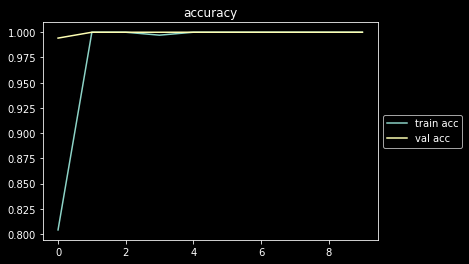

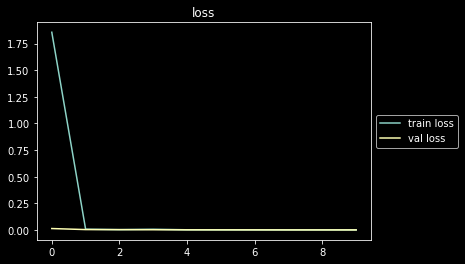

346/346 [==============================] - 0s 885us/step
test loss: 0.003339221017085947
test acc: 1.0


In [10]:
from keras import layers, models, backend
import numpy as np
import matplotlib.pyplot as plt
import os

# CONST VAL
DUMP_DIR = os.getenv('HOME') + "/teraken_overtime_dump"
DATASET_DIR = os.getenv('HOME') + "/teraken_overtime_dump/labeled"
LABEL_NAME = ['not_north', 'north']

%matplotlib inline

def to_grayscale(X):
    L_FILTER = backend.constant([[[[0.21 , 0.72 , 0.07]]]])
    return backend.sum(X * L_FILTER, axis=-1, keepdims=False)

def create_model():
    RESIZE_VAL = 150 # resized by 150
    model = models.Sequential()
    model.add(layers.Lambda((lambda X:backend.sum(X * backend.constant([[[[0.21 , 0.72 , 0.07]]]]), axis=-1, keepdims=False)), input_shape=(RESIZE_VAL, RESIZE_VAL, 3)))
    model.add(layers.Flatten()) # flatten layer
    model.add(layers.Dense(1, activation="sigmoid")) # logistic regression (output)

    model.summary() # show summary

    model.compile(loss="binary_crossentropy", optimizer='sgd', metrics=["acc"]) # compile model
    return model

def train_model(model, datasets_path):
    X_train, X_val, X_test, y_train, y_val, y_test = np.load(datasets_path)
    X_train = X_train.astype("float") / 255
    X_val = X_val.astype("float")  / 255
    model_stack = model.fit(X_train, y_train, epochs=10, batch_size=6, validation_data=(X_val, y_val))
    return model_stack

def show_history(model_stack):
    acc = model_stack.history['acc']
    val_acc = model_stack.history['val_acc']
    loss = model_stack.history['loss']
    val_loss = model_stack.history['val_loss']

    # plot learning curve
    epoch = range(len(acc))
    plt.style.use('dark_background')
    plt.plot(epoch, acc, label="train acc")
    plt.plot(epoch, val_acc, label="val acc")
    plt.title("accuracy")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

    plt.plot(epoch, loss, label='train loss')
    plt.plot(epoch, val_loss, label='val loss')
    plt.title('loss')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

def evaluate_data(model, datasets_path):
    X_train, X_val, X_test, y_train, y_val, y_test = np.load(datasets_path)
    X_test  = X_test.astype("float")  / 255
    eval_stack = model.evaluate(x=X_test, y=y_test)
    return eval_stack

def main():
    datasets_path = DUMP_DIR + "/north_datasets.npy"
    model = create_model()

    model_stack = train_model(model, datasets_path) # training model
    show_history(model_stack)

    # evaluate by testsets
    eval_stack = evaluate_data(model, datasets_path)
    print("test loss: " + str(eval_stack[0]))
    print("test acc: " + str(eval_stack[1]))

    # save model
    model_string = model.to_json()
    open(DUMP_DIR + "/north_model_logistic.json", 'w').write(model_string)

    # save parameter
    model.save_weights(DUMP_DIR + "/north_params_logistic.hdf5")

if __name__ == "__main__":
    main()


## ロジスティック回帰(グレースケール)による分類の考察
現時点では驚くべきことに精度がとても良い．  
グレースケール変換によってすべての画像を同じ色空間で比較できるようになった点が影響しているかもしれない(夜間の画像はグレースケールに変換して出力されている)．  

データセットを1週間として日付の偏り解消した上で再出力させてみても，精度がよく収束しているように見られる．

## CNN(グレースケール)による分類

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_11 (Lambda)           (None, 150, 150, 1)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 17, 17, 128)       0         
__________

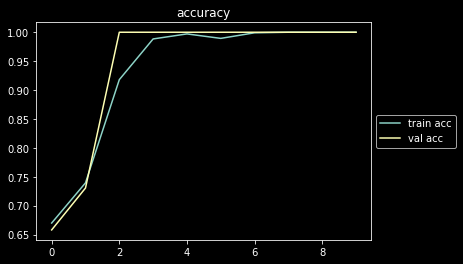

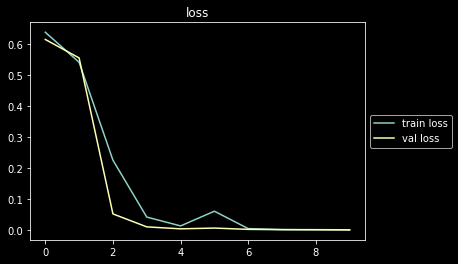

346/346 [==============================] - 5s 13ms/step
test loss: 0.00185847911170167
test acc: 1.0


In [12]:
from keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import os

# CONST VAL
DUMP_DIR = os.getenv('HOME') + "/teraken_overtime_dump"
DATASET_DIR = os.getenv('HOME') + "/teraken_overtime_dump/labeled"
LABEL_NAME = ['not_north', 'north']

%matplotlib inline

def to_grayscale(X):
    L_FILTER = backend.constant([[[[0.21 , 0.72 , 0.07]]]])
    return backend.sum(X * L_FILTER, axis=-1, keepdims=True)

def create_model():
    RESIZE_VAL = 150 # resized by 150
    model = models.Sequential()
    model.add(layers.Lambda(to_grayscale, input_shape=(RESIZE_VAL, RESIZE_VAL, 3)))
    model.add(layers.Conv2D(32, (3, 3), activation="relu")) # conv layer
    model.add(layers.MaxPooling2D((2, 2))) # pooling layer
    model.add(layers.Conv2D(64, (3, 3), activation="relu")) # conv layer
    model.add(layers.MaxPooling2D((2, 2))) # pooling layer
    model.add(layers.Conv2D(128, (3, 3), activation="relu")) # conv layer
    model.add(layers.MaxPooling2D((2, 2))) # pooling layer
    model.add(layers.Conv2D(128, (3, 3), activation="relu")) # conv layer
    model.add(layers.MaxPooling2D((2, 2))) # pooling layer
    model.add(layers.Flatten()) # flatten layer
    model.add(layers.Dense(512, activation="relu")) # fully connect layer 1
    model.add(layers.Dense(1, activation="sigmoid")) # fully connect layer 2 (output)

    model.summary() # show summary

    model.compile(loss="binary_crossentropy", optimizer='sgd', metrics=["acc"]) # compile model
    return model

def train_model(model, datasets_path):
    X_train, X_val, X_test, y_train, y_val, y_test = np.load(datasets_path)
    X_train = X_train.astype("float") / 255
    X_val = X_val.astype("float")  / 255
    model_stack = model.fit(X_train, y_train, epochs=10, batch_size=6, validation_data=(X_val, y_val))
    return model_stack

def show_history(model_stack):
    acc = model_stack.history['acc']
    val_acc = model_stack.history['val_acc']
    loss = model_stack.history['loss']
    val_loss = model_stack.history['val_loss']

    # plot learning curve
    epoch = range(len(acc))
    plt.style.use('dark_background')
    plt.plot(epoch, acc, label="train acc")
    plt.plot(epoch, val_acc, label="val acc")
    plt.title("accuracy")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

    plt.plot(epoch, loss, label='train loss')
    plt.plot(epoch, val_loss, label='val loss')
    plt.title('loss')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

def evaluate_data(model, datasets_path):
    X_train, X_val, X_test, y_train, y_val, y_test = np.load(datasets_path)
    X_test  = X_test.astype("float")  / 255
    eval_stack = model.evaluate(x=X_test, y=y_test)
    return eval_stack

def main():
    datasets_path = DUMP_DIR + "/north_datasets.npy"
    model = create_model()

    model_stack = train_model(model, datasets_path) # training model
    show_history(model_stack)

    # evaluate by testsets
    eval_stack = evaluate_data(model, datasets_path)
    print("test loss: " + str(eval_stack[0]))
    print("test acc: " + str(eval_stack[1]))

    # save model
    model_string = model.to_json()
    open(DUMP_DIR + "/north_model_cnn_gray.json", 'w').write(model_string)

    # save parameter
    model.save_weights(DUMP_DIR + "/north_params_cnn_gray.hdf5")

if __name__ == "__main__":
    main()


# Conclusion
結論として，カラー画像としてCNNを通すのが現時点で一番良いと考えられる．  
ロジスティック回帰も健闘しているが，テストセットまで見るとlossを小さく抑えられているのはCNNのようだ．  
グレースケールCNNの精度がイマイチだったのは，色変換により情報を大きく削ぎ落としているからだろう．  

より精度のことを考えるのならば，画像の色空間によって別モデルを組むことなどが有効と考えるが，現時点で高精度の識別ができているため今回は飛ばす．